In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

### Загрузка данных

In [2]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


In [6]:
df = movies.merge(ratings, on='movieId')

In [7]:
df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


### Обработка данных

In [9]:
df.drop(columns="timestamp", axis=1,inplace=True)

In [10]:
df["YearPublic"] = df["title"].str.extract(r'\((\d{4})\)')

In [11]:
df["title"] = df["title"].str.replace(r'\(\d{4}\)', '', regex=True)

In [12]:
df['genres'].value_counts()

genres
Comedy                             7196
Drama                              6291
Comedy|Romance                     3967
Comedy|Drama|Romance               3000
Comedy|Drama                       2851
                                   ... 
Comedy|Mystery|Romance|Thriller       1
Comedy|Sci-Fi|War                     1
Action|Animation|Comedy|Fantasy       1
Animation|Crime|Drama                 1
Fantasy|Horror|Sci-Fi|Western         1
Name: count, Length: 951, dtype: int64

In [13]:
all_genres = df['genres'].str.split('|').explode()
genre_counts = all_genres.value_counts()
print("Частота жанров:")
print(genre_counts)

Частота жанров:
genres
Drama                 41928
Comedy                39053
Action                30635
Thriller              26452
Adventure             24161
Romance               18124
Sci-Fi                17243
Crime                 16681
Fantasy               11834
Children               9208
Mystery                7674
Horror                 7291
Animation              6988
War                    4859
IMAX                   4145
Musical                4138
Western                1930
Documentary            1219
Film-Noir               870
(no genres listed)       47
Name: count, dtype: int64


In [14]:
df = df[df['genres'] != '(no genres listed)']

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100789 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   movieId     100789 non-null  int64  
 1   title       100789 non-null  object 
 2   genres      100789 non-null  object 
 3   userId      100789 non-null  int64  
 4   rating      100789 non-null  float64
 5   YearPublic  100781 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 5.4+ MB


In [16]:
df.dropna(inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_4028\1379821321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [17]:
df_split_genre = df.copy()

In [18]:
genres_split = df['genres'].str.get_dummies(sep='|')
df_split_genre = pd.concat([df, genres_split], axis=1)

In [19]:
df_split_genre.drop(columns='genres', axis=1, inplace=True)

In [20]:
df_split_genre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100781 entries, 0 to 100835
Data columns (total 24 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   movieId      100781 non-null  int64  
 1   title        100781 non-null  object 
 2   userId       100781 non-null  int64  
 3   rating       100781 non-null  float64
 4   YearPublic   100781 non-null  object 
 5   Action       100781 non-null  int64  
 6   Adventure    100781 non-null  int64  
 7   Animation    100781 non-null  int64  
 8   Children     100781 non-null  int64  
 9   Comedy       100781 non-null  int64  
 10  Crime        100781 non-null  int64  
 11  Documentary  100781 non-null  int64  
 12  Drama        100781 non-null  int64  
 13  Fantasy      100781 non-null  int64  
 14  Film-Noir    100781 non-null  int64  
 15  Horror       100781 non-null  int64  
 16  IMAX         100781 non-null  int64  
 17  Musical      100781 non-null  int64  
 18  Mystery      100781 non-null 

In [21]:
df_split_genre

,movieId,title,userId,rating,YearPublic,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1,4.0,1995,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,Toy Story,5,4.0,1995,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,Toy Story,7,4.5,1995,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,Toy Story,15,2.5,1995,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,Toy Story,17,4.5,1995,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic,184,4.0,2017,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
100832,193583,No Game No Life: Zero,184,3.5,2017,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
100833,193585,Flint,184,3.5,2017,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100834,193587,Bungo Stray Dogs: Dead Apple,184,3.5,2018,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Краткая визуализация данных

In [22]:
genre_columns = [col for col in df_split_genre.columns if col not in ['movieId', 'title', 'userId', 'rating', 'YearPublic']]

Распределение жанров по фильмам после One-Hot Encoding:
Drama          41926
Comedy         39053
Action         30631
Thriller       26447
Adventure      24161
Romance        18124
Sci-Fi         17237
Crime          16681
Fantasy        11834
Children        9208
Mystery         7674
Horror          7291
Animation       6988
War             4859
IMAX            4145
Musical         4138
Western         1930
Documentary     1219
Film-Noir        870
dtype: int64


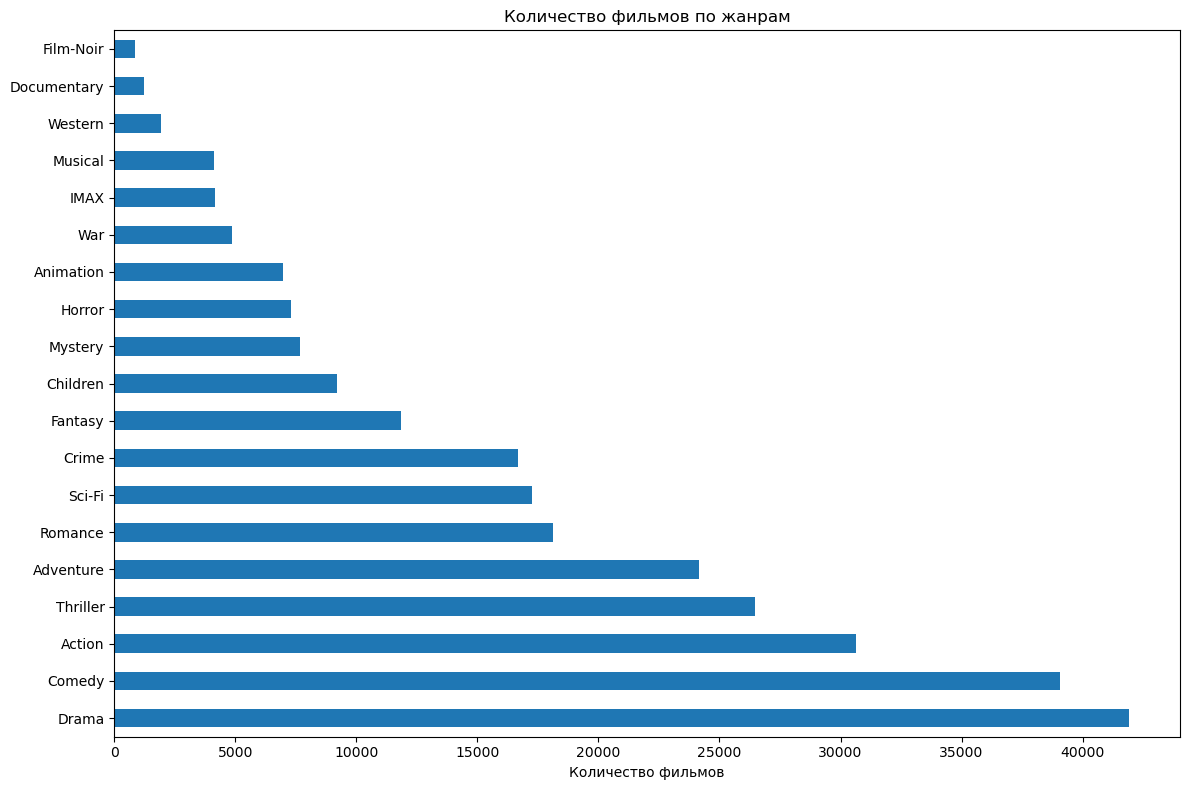

In [23]:
genre_counts = genres_split.sum().sort_values(ascending=False)

print("Распределение жанров по фильмам после One-Hot Encoding:")
print(genre_counts)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
genre_counts.head(20).plot(kind='barh')
plt.title('Количество фильмов по жанрам')
plt.xlabel('Количество фильмов')
plt.tight_layout()
plt.show()

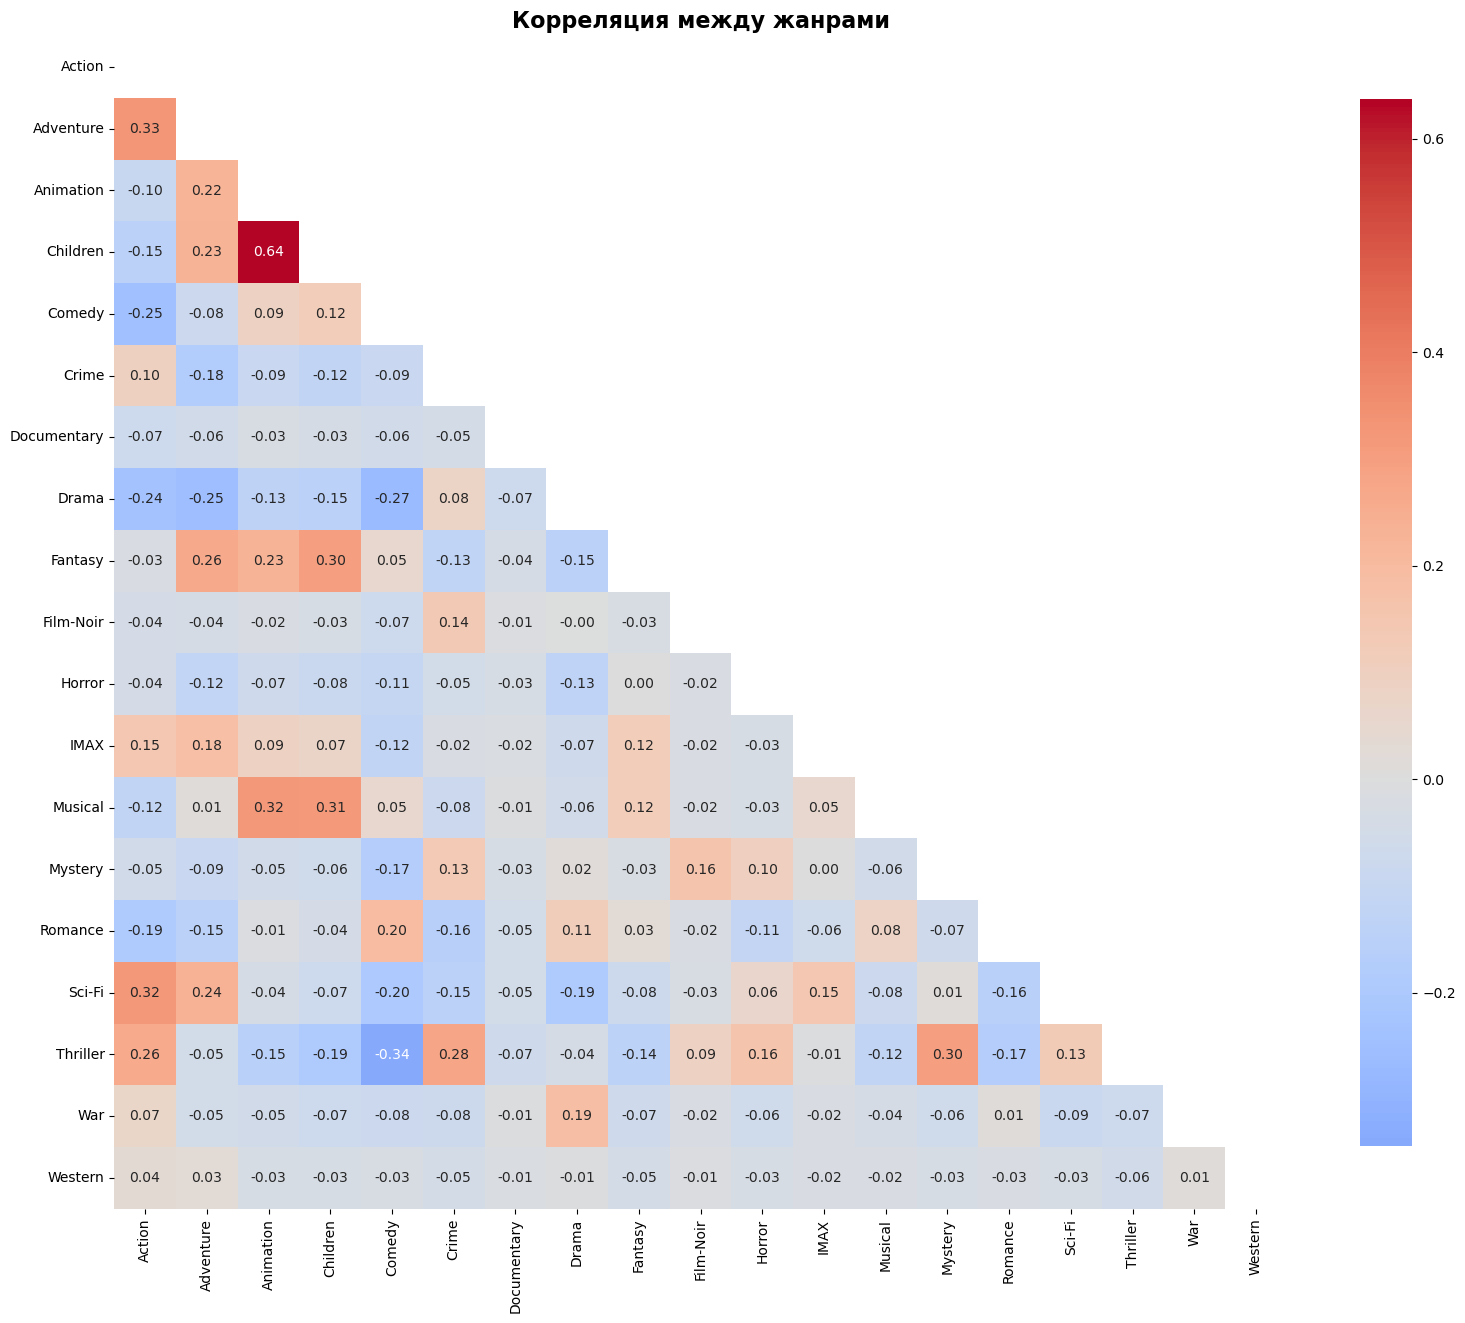

In [24]:
genre_correlation = df_split_genre[genre_columns].corr()

plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(genre_correlation, dtype=bool))
sns.heatmap(genre_correlation, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Корреляция между жанрами', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [25]:
genre_ratings = {}
for genre in genre_columns:
    genre_ratings[genre] = df_split_genre[df_split_genre[genre] == 1]['rating'].mean()

genre_ratings_series = pd.Series(genre_ratings).sort_values(ascending=False)
genre_sums = df_split_genre[genre_columns].sum().sort_values(ascending=False)
genre_stats = pd.DataFrame({
    'Количество фильмов': genre_sums,
    'Доля от общего числа (%)': (genre_sums / len(df_split_genre) * 100).round(2),
    'Средний рейтинг': genre_ratings_series.round(2),
})

print(genre_stats.sort_values('Количество фильмов', ascending=False).head(15))

           Количество фильмов  Доля от общего числа (%)  Средний рейтинг
Drama                   41926                     41.60             3.66
Comedy                  39053                     38.75             3.38
Action                  30631                     30.39             3.45
Thriller                26447                     26.24             3.49
Adventure               24161                     23.97             3.51
Romance                 18124                     17.98             3.51
Sci-Fi                  17237                     17.10             3.46
Crime                   16681                     16.55             3.66
Fantasy                 11834                     11.74             3.49
Children                 9208                      9.14             3.41
Mystery                  7674                      7.61             3.63
Horror                   7291                      7.23             3.26
Animation                6988                      

In [26]:
df = df_split_genre

### Рекомендательные системы

Топ 10 популярных фильмов (на основе взвешенных рейтингов)

In [27]:
avg_ratings = df.groupby(['movieId', 'title'])['rating'].mean().reset_index().rename(columns={'rating': 'avg_rating'})
avg = pd.DataFrame(avg_ratings).sort_values('avg_rating', ascending=False)

In [28]:
avg_ratings.head()

,movieId,title,avg_rating
0,1,Toy Story,3.920930
1,2,Jumanji,3.431818
2,3,Grumpier Old Men,3.259615
3,4,Waiting to Exhale,2.357143
4,5,Father of the Bride Part II,3.071429


In [29]:
avg.head()

,movieId,title,avg_rating
48,53,Lamerica,5.0
7181,72692,Mickey's Once Upon a Christmas,5.0
7221,73822,Meantime,5.0
7231,74226,"Dream of Light (a.k.a. Quince Tree Sun, The) (...",5.0
8916,136469,Larry David: Curb Your Enthusiasm,5.0


In [30]:
cnt_ratings = df.groupby(['movieId', 'title'])['rating'].count().reset_index().rename(columns={'rating': 'count_rating'})
cnt = pd.DataFrame(cnt_ratings).sort_values('count_rating', ascending=False)

In [31]:
cnt.head()

,movieId,title,count_rating
314,356,Forrest Gump,329
277,318,"Shawshank Redemption, The",317
257,296,Pulp Fiction,307
510,593,"Silence of the Lambs, The",279
1938,2571,"Matrix, The",278


In [32]:
popularite = avg.merge(cnt, on=['movieId', 'title'])
popularite.head()

,movieId,title,avg_rating,count_rating
0,53,Lamerica,5.0,2
1,72692,Mickey's Once Upon a Christmas,5.0,1
2,73822,Meantime,5.0,1
3,74226,"Dream of Light (a.k.a. Quince Tree Sun, The) (...",5.0,1
4,136469,Larry David: Curb Your Enthusiasm,5.0,1


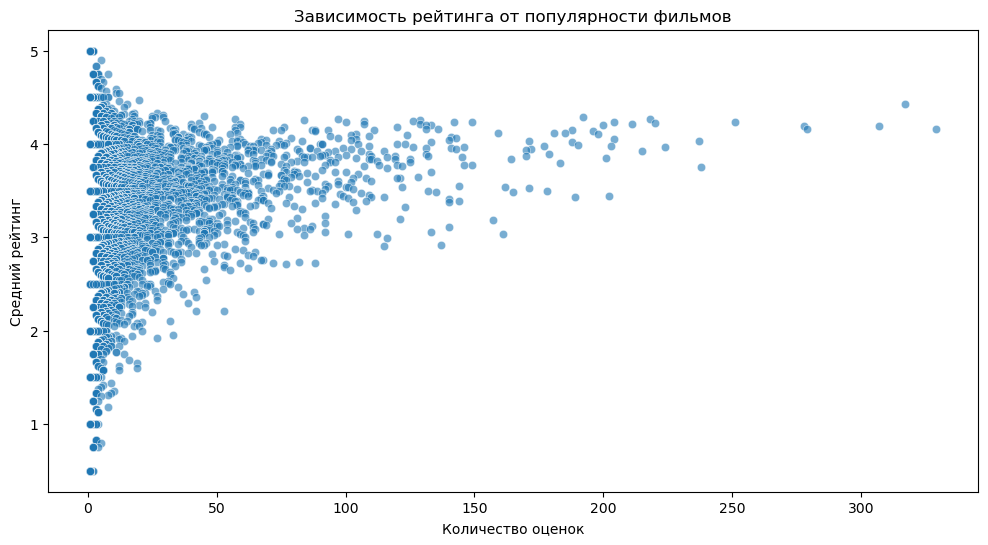

In [33]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=popularite, x='count_rating', y='avg_rating', alpha=0.6)
plt.xlabel('Количество оценок')
plt.ylabel('Средний рейтинг')
plt.title('Зависимость рейтинга от популярности фильмов')
plt.show()

In [34]:
print("Статистика по количеству оценок ДО нормализации:")
print(popularite["count_rating"].describe())

Статистика по количеству оценок ДО нормализации:
count    9686.000000
mean       10.404811
std        22.437812
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: count_rating, dtype: float64


In [35]:
scaler = MinMaxScaler(feature_range=(0.3, 1))
v_normalized = scaler.fit_transform(popularite[["count_rating"]]).flatten()
popularite['count_rating_normalized'] = v_normalized

In [36]:
print("Статистика по количеству оценок ПОСЛЕ нормализации:")
print(popularite['count_rating_normalized'].describe())

Статистика по количеству оценок ПОСЛЕ нормализации:
count    9686.000000
mean        0.320071
std         0.047886
min         0.300000
25%         0.300000
50%         0.304268
75%         0.317073
max         1.000000
Name: count_rating_normalized, dtype: float64


In [37]:
v = popularite["count_rating"]
v_norm = popularite["count_rating_normalized"]
R = popularite["avg_rating"]    
m = v.quantile(0.90)           
c = R.mean()                  

In [38]:
popularite['w_score_original'] = ((v * R) + (m * c)) / (v + m)
popularite['w_score_normalized'] = ((v_norm * R) + (m * c)) / (v_norm + m)

In [39]:
results = {}

methods = [
    ('w_score_original', 'Оригинальный метод'),
    ('w_score_normalized', 'MinMax нормализация')
]

for method_col, method_name in methods:
    pop_sort = popularite.sort_values(method_col, ascending=False)
    results[method_name] = pop_sort.head(10)

In [40]:
for method_name, result_df in results.items():
    print(f"\n{method_name}:")
    top10 = result_df[['title', 'avg_rating', 'count_rating', 'w_score_original', 'w_score_normalized']]
    print(top10.to_string(index=False))


Оригинальный метод:
                                          title  avg_rating  count_rating  w_score_original  w_score_normalized
                     Shawshank Redemption, The     4.429022           317          4.337424            3.302644
                                Godfather, The     4.289062           192          4.162438            3.288225
                                    Fight Club     4.272936           218          4.161526            3.289782
            Star Wars: Episode IV - A New Hope     4.231076           251          4.136956            3.291016
                           Usual Suspects, The     4.237745           204          4.123696            3.287792
                                  Pulp Fiction     4.197068           307          4.121479            3.293875
                              Schindler's List     4.225000           220          4.119732            3.288608
                                   Matrix, The     4.192446           278          

Топ 10 рекомендованных фильмов по жанру

In [41]:
avg_ratings = df.groupby(['movieId', 'title'])['rating'].mean().reset_index().rename(columns={'rating': 'avg_rating'})
cnt_ratings = df.groupby(['movieId', 'title'])['rating'].count().reset_index().rename(columns={'rating': 'count_rating'})
popularite = avg_ratings.merge(cnt_ratings, on=['movieId', 'title'])

In [42]:
movies_with_genres = df[['movieId'] + genre_columns].drop_duplicates()
popularite_with_genres = popularite.merge(movies_with_genres, on='movieId')

In [43]:
v = popularite_with_genres["count_rating"]
R = popularite_with_genres["avg_rating"]    
m = v.quantile(0.90)           
c = R.mean()
popularite_with_genres['w_score_original'] = ((v * R) + (m * c)) / (v + m)

In [44]:
genre_stats = []
for genre in genre_columns:
    genre_movies = popularite_with_genres[popularite_with_genres[genre] == 1]
    avg_weighted = genre_movies['w_score_original'].mean()
    movie_count = len(genre_movies)
    total_ratings = genre_movies['count_rating'].sum()
    avg_rating = genre_movies['avg_rating'].mean()
    genre_stats.append({
        'genre': genre,
        'avg_weighted_score': avg_weighted,
        'movie_count': movie_count,
        'total_ratings': total_ratings,
        'avg_rating': avg_rating
    })

In [45]:
genre_df = pd.DataFrame(genre_stats)
top_10_genres = genre_df.nlargest(10, 'avg_weighted_score')

In [46]:
top10 = top_10_genres[['genre', 'avg_weighted_score', 'movie_count', 'total_ratings', 'avg_rating']]
print(top10.to_string(index=False))

      genre  avg_weighted_score  movie_count  total_ratings  avg_rating
  Film-Noir            3.378302           85            870    3.670471
        War            3.343884          381           4859    3.571655
       IMAX            3.337763          158           4145    3.311996
    Western            3.316065          167           1930    3.383389
  Animation            3.314537          610           6988    3.497119
    Mystery            3.314325          573           7674    3.330364
      Drama            3.312275         4347          41926    3.420639
      Crime            3.311755         1196          16681    3.301844
    Musical            3.305764          333           4138    3.296371
Documentary            3.305279          438           1219    3.781682


Топ 10 рекомендованных фильмов по названию фильма

In [47]:
movies_df = df[['movieId', 'title']].drop_duplicates()

In [48]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1)
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df['title'])

In [49]:
input_vector = tfidf_vectorizer.transform(["Toy Story"])
similarities = cosine_similarity(input_vector, tfidf_matrix).flatten()

In [50]:
results_df = movies_df.copy()
results_df['similarity_score'] = similarities  

In [51]:
results_df = results_df[results_df['title'] != "Toy Story"]
results_df = results_df.sort_values('similarity_score', ascending=False)

In [52]:
final_results = results_df.head(10).merge(
    df[genre_columns + ['movieId']].drop_duplicates(subset=['movieId']),
    on='movieId',
    how='left'
)

In [53]:
for idx, row in final_results.iterrows():
    print(f"{row['title']} - {row['similarity_score']:.3f}")

Toy Story  - 1.000
Toy Story 2  - 1.000
Toy Story 3  - 1.000
L.A. Story  - 0.431
Toy, The  - 0.406
Toy Soldiers  - 0.347
Love Story  - 0.214
Christmas Story, A  - 0.196
Ghost Story  - 0.196
True Story  - 0.194


Топ 10 рекомендованных фильмов по контенту (коллаборативная
фильтрация)

In [54]:
def enhanced_collaborative_filtering(user_id, n_recommendations=10):
    try:
        user_item_matrix = df.pivot_table(index='userId', columns='movieId', values='rating')
        
        user_means = user_item_matrix.mean(axis=1)
        user_item_centered = user_item_matrix.sub(user_means, axis=0)
        user_item_filled = user_item_centered.fillna(0)
        
        user_similarity = cosine_similarity(user_item_filled)
        
        if user_id not in user_item_matrix.index:
            available_users = list(user_item_matrix.index)
            return [], [], f"Пользователь {user_id} не найден"
        
        user_index = user_item_matrix.index.get_loc(user_id)
        
        similar_users_indices = []
        similarity_scores = []
        
        for i in range(len(user_similarity[user_index])):
            if i != user_index and user_similarity[user_index][i] > 0.1:
                similar_users_indices.append(i)
                similarity_scores.append(user_similarity[user_index][i])
        
        if not similar_users_indices:
            similar_users_indices = np.argsort(user_similarity[user_index])[::-1][1:11]
            similarity_scores = [user_similarity[user_index][i] for i in similar_users_indices]
        
        user_rated_movies = df[df['userId'] == user_id]['movieId'].values
        
        candidates = {}
        
        for similar_user_idx, similarity_score in zip(similar_users_indices, similarity_scores):
            similar_user_id = user_item_matrix.index[similar_user_idx]
            
            similar_user_ratings = df[(df['userId'] == similar_user_id) & (df['rating'] >= 3.5)]
            
            for _, movie_row in similar_user_ratings.iterrows():
                movie_id = movie_row['movieId']
                
                if movie_id in user_rated_movies:
                    continue
                
                if movie_id not in candidates:
                    movie_title = movie_row['title']
                    candidates[movie_id] = {
                        'title': movie_title,
                        'total_weighted_rating': 0,
                        'total_similarity': 0,
                        'rating_count': 0
                    }
                
                candidates[movie_id]['total_weighted_rating'] += movie_row['rating'] * similarity_score
                candidates[movie_id]['total_similarity'] += similarity_score
                candidates[movie_id]['rating_count'] += 1
        
        recommendations = []
        for movie_id, data in candidates.items():
            if data['total_similarity'] > 0 and data['rating_count'] >= 2:
                predicted_rating = data['total_weighted_rating'] / data['total_similarity']
                predicted_rating = max(1.0, min(5.0, predicted_rating))
                
                avg_similarity = data['total_similarity'] / data['rating_count']
                confidence = avg_similarity * np.log1p(data['rating_count'])
                confidence = min(1.0, confidence)
                
                recommendations.append({
                    'movie_id': movie_id,
                    'title': data['title'],
                    'predicted_rating': predicted_rating,
                    'confidence': confidence,
                    'recommendation_count': data['rating_count']
                })
        
        recommendations.sort(key=lambda x: (x['predicted_rating'], x['confidence']), reverse=True)
        
        high_rated_movies = get_user_high_rated_movies(user_id, df)
        
        return high_rated_movies, recommendations[:n_recommendations]
        
    except Exception as e:
        return [], []

In [59]:
def get_user_high_rated_movies(user_id, df, min_rating=4.0, limit=10):
    try:
        user_movies = df[(df['userId'] == user_id) & (df['rating'] >= min_rating)]
        user_movies = user_movies.sort_values('rating', ascending=False).head(limit)
        
        high_rated = []
        for _, row in user_movies.iterrows():
            high_rated.append({
                'movie_id': row['movieId'],
                'title': row['title'],
                'user_rating': row['rating']
            })
        return high_rated
    except Exception as e:
        return []

In [60]:
high_rated_movies, recommendations = enhanced_collaborative_filtering(152, 10)

if high_rated_movies or recommendations:
    print("Высокооцененные фильмы пользователя:")
    if high_rated_movies:
        for i, movie in enumerate(high_rated_movies, 1):
            print(f"{i}. {movie['title']}")
            print(f"   Оценка: {movie['user_rating']}")
    else:
        print("Не найдено высокооцененных фильмов")
    
    print("\nРекомендуемые фильмы:")
    if recommendations:
        for i, movie in enumerate(recommendations, 1):
            print(f"{i}. {movie['title']}")
            print(f"   Предсказанная оценка: {movie['predicted_rating']:.2f}")
            print(f"   Уверенность: {movie['confidence']:.2f}")
    else:
        print("Не найдено рекомендаций")

Высокооцененные фильмы пользователя:
1. Seven (a.k.a. Se7en) 
   Оценка: 5.0
2. Taxi Driver 
   Оценка: 5.0
3. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb 
   Оценка: 5.0
4. Godfather, The 
   Оценка: 5.0
5. Fight Club 
   Оценка: 5.0
6. Eternal Sunshine of the Spotless Mind 
   Оценка: 5.0
7. American History X 
   Оценка: 5.0
8. Hurt Locker, The 
   Оценка: 5.0
9. 12 Angry Men 
   Оценка: 5.0
10. Pulp Fiction 
   Оценка: 4.5

Рекомендуемые фильмы:
1. Graduate, The 
   Предсказанная оценка: 5.00
   Уверенность: 0.25
2. Inglourious Basterds 
   Предсказанная оценка: 5.00
   Уверенность: 0.16
3. Lock, Stock & Two Smoking Barrels 
   Предсказанная оценка: 5.00
   Уверенность: 0.14
4. Limitless 
   Предсказанная оценка: 5.00
   Уверенность: 0.13
5. Wolf of Wall Street, The 
   Предсказанная оценка: 5.00
   Уверенность: 0.13
6. Good Will Hunting 
   Предсказанная оценка: 5.00
   Уверенность: 0.13
7. Beautiful Mind, A 
   Предсказанная оценка: 5.00
   Уверенность: 0

In [75]:
def get_top_movies_by_genre(genre):
    genre_movies = df[df[genre] == 1]
    
    movie_stats = genre_movies.groupby(['movieId', 'title']).agg({
        'rating': ['mean', 'count'],
        'YearPublic': 'first'
    }).round(2)
    
    movie_stats.columns = ['avg_rating', 'rating_count', 'year']
    movie_stats = movie_stats.reset_index()
    
    movie_stats = movie_stats[movie_stats['rating_count'] >= 10]
    
    if movie_stats.empty:
        print(f"Нет фильмов в жанре '{genre}' с достаточным количеством оценок")
        return []
    
    top_movies = movie_stats.sort_values(['avg_rating', 'rating_count'], ascending=[False, False])
    
    top_10 = top_movies.head(10)
    
    result = []
    for idx, row in top_10.iterrows():
        result.append({
            'rank': len(result) + 1,
            'title': row['title'],
            'year': row['year'],
            'avg_rating': row['avg_rating'],
            'rating_count': row['rating_count'],
            'genre': genre
        })
    
    return result

In [87]:
top_action = get_top_movies_by_genre('Action')
for i, movie in enumerate(top_action, 1):
    print(f"{movie['title']} {movie['avg_rating']:.2f}/5.0")

All Quiet on the Western Front  4.35/5.0
Once Upon a Time in the West (C'era una volta il West)  4.31/5.0
Elite Squad (Tropa de Elite)  4.30/5.0
Logan  4.28/5.0
Fight Club  4.27/5.0
Outlaw Josey Wales, The  4.25/5.0
Dark Knight, The  4.24/5.0
Star Wars: Episode IV - A New Hope  4.23/5.0
Princess Bride, The  4.23/5.0
Yojimbo  4.23/5.0


In [57]:
df.to_csv('Films.csv', index=False)